# Advanced Machine Learning (GR5242) Final Project Submission
### December 17, 2017
### Xinyi Huang (xh2294), Shi (Edwin) Bai (sb3878) and Hongfeng Jiang (hj2443)

## Project 1: CIFAR-10 Image Classification

The goal of this project is to classify images from [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks). We will first preprocess the images, then build several convolutional neural networks by applying algorithms we learned from class and from our own research on training set. After that, we compare the performance with validation data for each network, and use the testing data to test the performance of selected model at the end.  

### Load useful packages

In [35]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf

### Prepare data

The original data comes with 5 training batches and 1 testing batch, with 10000 data in each batch. For this project, we wish to have a validation set to compare the performance of the trained networks. Thus, we combined the 5 training batches and take 10% (5000 in total) of the pictures from the end of the combined set as the validation set. We keep the testing batch as is to be the testing set.

In [143]:
## download python version of data from https://www.cs.toronto.edu/~kriz/cifar.html 
## and save to ./data

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

def get_data(train=True, n_val=5000):

    ## input all 5 batches
    if train == True:
        first = True
        for i in range(5):
            file = "./data/cifar-10-batches-py/data_batch_" + str(i+1)
            this_batch = unpickle(file)
            this_labels = np.array(this_batch["labels"])
            this_labels_one_hot = (np.arange(10) == this_labels[:, None]).astype(np.float32)
            this_img = this_batch["data"].reshape(-1,3,32,32).transpose(0,2,3,1)
            
            if first is True:
                img = this_img
                labels_one_hot = this_labels_one_hot
                first = False
            
            else:
                img = np.concatenate((img, this_img), axis=0)
                labels_one_hot = np.concatenate((labels_one_hot, this_labels_one_hot), axis=0)
        
        n = img.shape[0]
        
        return img[:n-n_val], labels_one_hot[:n-n_val], img[-n_val:], labels_one_hot[-n_val:]
    
    ## input test batch
    else:
        file = "./data/cifar-10-batches-py/test_batch"
        this_batch = unpickle(file)
        this_labels = np.array(this_batch["labels"])
        labels_one_hot = (np.arange(10) == this_labels[:, None]).astype(np.float32)
        img = this_batch["data"].reshape(-1,3,32,32).transpose(0,2,3,1)
        
    
        return img, labels_one_hot


In [144]:
x_train, y_train, x_val, y_val = get_data()
x_test, y_test = get_data(train=False)

#### Check data dimensions, and set validation set size

In [256]:
x_train.shape
batch_size = 100
train_size = x_train.shape[0]
val_size = 5000

(45000, 32, 32, 3)

#### Check data and one-hot encoding

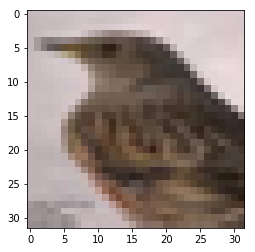

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [246]:
ind = np.random.randint(0,x_train.shape[1],1)[0]
plt.imshow(x_train[ind])
plt.show()
print(y_train[ind])

### Compute cross entropy and accuracy, adopted from lecture notes 

In [156]:
def compute_cross_entropy(logits, y):
    softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(softmax_cross_entropy, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

### Build Convolutional Neural Network

### Network 1:  Convolutional Layer -> Mixed Max & Average Pooling -> Fully Connected layer
1. **Convolutional Layer:** Applies 5\*5\*16 filter and 1\*1 stride, with ReLU activation function. 
2. **Mixed Pooling Layer:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Fully Connected Layer:** Implements the flatten function to change the dimension and the uses softmax activation.

### Logic behind this network:
This is the first and simplest network we tried.
1. For Convolutional Layer, the reason why we used 5\*5\*16 filter and 1\*1 stride is that we would like to capture local features by using relative smaller filter size and move the filter one pixel at a time. Since this model is relative simple and the computation is not that expensive, we care less about producing smaller output volumes spatially by using larger filter size. 

2. We learned from class that pooling is a very common and important trick of the trade. People often use this intermediate layer as a subsampling layer which represent more robust to the effects of variations in data while still remaining the expressivity. Therefore we decided to add one pooling layer after the convolutional layer as it is a very good way to control overfitting. However, there are many options for us and the most commonly used are max pooling and average pooling. We considered a lot about which pooling method we should use in this project. Should we care more about the precise location or relative location to the other features? In our project, we combined max and average pooling functions to improve performance of our network. We got inspired by the paper called *[‘Generalizing Pooling Functions in Convolutional Neural Networks: Mixed, Gated, and Tree’ written by Chen-Yu Lee, Patrick W. Gallagher and Zhuowen Tu](https://arxiv.org/pdf/1509.08985.pdf)*. To be more specific, we used 50/50 mix, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. We used this method because the classification error (in %) of 50/50 mix is smaller than the error of baseline model (trained with conventional max pooling). The statistics are shown in the Table 1 of this paper and the classification error (in %) of 50/50 mix is $8.11\pm 0.10$ while the classification error of baseline is 9.10. Another nice thing of this method is that there is only a light increase in computational overhead during training but it has a relative large increase in the performance. 

3. The output from convolutional and pooling layers represent high-level features of the input. We decided to add a fully connected layer to use these features to classify the input image into ten classes based on the training dataset. We used softmax activation since it is the most commonly used when there are n number of classes. 

In [203]:
def compute_logits_model_1(x):
    """Compute the logits of the model"""

    n1 = 16
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine max pool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # fc 1
    h_pool1_flat = tf.reshape(h_pool1_mixed, [-1, 32*32*n1]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[32*32*n1, 10]) # 32*32*16 -> 10
    b_fc1 = tf.get_variable('b_fc1', shape=[10])
    logits = tf.add(tf.matmul(h_pool1_flat, W_fc1), b_fc1)
    
    return logits

### Run Model 1

In [263]:
# define model
model = 1
dir_name = "logs/" + str(model)

In [265]:
tf.reset_default_graph()
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_1(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
        
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(20001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
        
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.1190
Step   0: Validation accuracy 0.1110
Step 500: Training accuracy 0.4400
Step 500: Validation accuracy 0.3914
Step 1000: Training accuracy 0.4750
Step 1000: Validation accuracy 0.4098
Step 1500: Training accuracy 0.4850
Step 1500: Validation accuracy 0.4064
Step 2000: Training accuracy 0.5060
Step 2000: Validation accuracy 0.4388
Step 2500: Training accuracy 0.5360
Step 2500: Validation accuracy 0.4560
Step 3000: Training accuracy 0.5550
Step 3000: Validation accuracy 0.4554
Step 3500: Training accuracy 0.5570
Step 3500: Validation accuracy 0.4752
Step 4000: Training accuracy 0.5880
Step 4000: Validation accuracy 0.4818
Step 4500: Training accuracy 0.5860
Step 4500: Validation accuracy 0.4804
Step 5000: Training accuracy 0.6020
Step 5000: Validation accuracy 0.5032
Step 5500: Training accuracy 0.6120
Step 5500: Validation accuracy 0.4866
Step 6000: Training accuracy 0.6260
Step 6000: Validation accuracy 0.4906
Step 6500: Training accuracy 0.6330
Step 6

### Network 1 Output: 
Validation accuracy for model 1 after 20000 steps is around 50%, which is not high enough. 

Although it is much higher than the theory random classifying--10%, we still want to find more accurate model. 

We guess that the model is too simple since it only contains one convolution and one pooling layer.It may not capture enough features during the classifying since the training accuracy is only around 80% (not completed learning) after 20000 steps. Therefore we will add more layers in next model.

### Network 2: Convolutional Layer 1 -> Mixed Max & Average Pooling 1 ->  Convolutional Layer 2 ->  Mixed Max & Average Pooling 2 -> Fully Connected Layer 1 -> Fully Connected Layer 2
1. **Convolutional Layer #1:** Applies 5\*5\*64 filter and 1\*1 stride, with ReLU activation function. 
2. **Mixed Pooling Layer #1:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Convolutional Layer #2:** Applies 3\*3\*128 filter and 2\*2 stride, with ReLU activation function. 
4. **Mixed Pooling Layer #2:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
5. **Fully Connected Layer #1:** 2048 neurons with ReLU activation
6. **Fully Connected Layer #2 (Logits Layer):** 10 neurons, one for each target class (0-9)

### Logic behind this network:
This is the second network we tried. 
1. Since the performance of the first network is not very good with validation accuracy around 50%, we decided to add one more convolutional layer and mix pooling layer to see if there will be any improvement. 

2. For the second Convolutional Layer, we applied 3\*3\*128 filter and 2\*2 stride. We increased stride in this case because of two reasons. Firstly, we used the stride of 1 in the first convolutional layer to get enough information so we cared less about information loss this time. And we thought that neighboring pixels are often strongly related and two pixels are less correlated if they are further apart from each other. Therefore we decided to increase the stride size in the second convolutional layer in order to get smaller spatial dimensions by making them overlap less. On the other hand, since the filter jump 2 pixels at a time as we slide them around, it will relatively reduce the computational complexity. In addition, we also considered that if we use a big stride, this will definitely lead to high information loss. Therefore, 2\*2 stride seemed to be a good choice in this case. 

3. The reason why we used 3\*3\*128 filter is that we wanted to control the information loss of applying a larger stride by using a smaller filter size.

4. Besides, we also increased stride in second pooling layer. Since this network is more complex than the first one, we wanted to reduce the number of parameters and increased the computation time. And hopefully without lossing much expressivity at the same time. 

5. In this case, we added one more fully connected layer. Since we applied convolutional layer and mixed pooling layer twice, the mapping became more complex correspondingly. Fully-connected layers are often considered as a semi-independent mapping of features to outputs, therefore we would like to use more than one fully connected layers to give us enough expressive power.   
  
6. For this fully connected layer, we used ReLU activation. There are two reasons behind this. The first one is higher computational efficiency (train faster for large networks) and almost same accuracy. This is discussed in details in paper called ['ImageNet Classification with Deep Convolutional Neural Networks'](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf). Another reason is that ReLU also helps to alleviate the vanishing gradient problem compared to sigmoid functions. We inspired by [this post](https://dzone.com/articles/a-beginners-guide-to-understanding-convolutional-n-1).  

In [271]:
def compute_logits_model_2(x):
    """Compute the logits of the model"""

    n1 = 64
    n2 = 128
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine maxpool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # cnn layer 2
    ## 3*3 filter with 2*2 stride: hope to capture distant features
    W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, n1, n2]) 
    b_conv2 = tf.get_variable('b_conv2', shape=[n2])
    h_conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool1_mixed, W_conv2, strides=[1,2,2,1], padding='SAME'), b_conv2))
    
    # cnn2 size 32*32 -> 16*16 (stride=2*2)
    
    
    # max pool 2
    h_pool2_max = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool2_avg = tf.nn.avg_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool2_mixed = tf.add(h_pool2_max, h_pool2_avg) * 0.5
    
    # pool 2 size 16*16 -> 8*8 (stride=2*2)
    
    
    # fc layer 1 8192 -> 2048
    h_conv2_flat = tf.reshape(h_pool2_mixed, [-1, 8*8*n2]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, 2048]) # 8192 -> 2048
    b_fc1 = tf.get_variable('b_fc1', shape=[2048])
    h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1))
    
    
    # softmax 2048 -> 10
    W_fc2 = tf.get_variable('W_fc2', shape=[2048, 10]) # 2048 -> 10
    b_fc2 = tf.get_variable('b_fc2', shape=[10])
    logits = tf.add(tf.matmul(h_fc1, W_fc2), b_fc2)

    return logits

### Run Model 2

In [289]:
# define model
model = 2
dir_name = "logs/" + str(model)

In [283]:
tf.reset_default_graph()

In [284]:
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_2(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
        
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(20001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.1160
Step   0: Validation accuracy 0.1200
Step 500: Training accuracy 0.6300
Step 500: Validation accuracy 0.5840
Step 1000: Training accuracy 0.7340
Step 1000: Validation accuracy 0.6450
Step 1500: Training accuracy 0.7840
Step 1500: Validation accuracy 0.6634
Step 2000: Training accuracy 0.8520
Step 2000: Validation accuracy 0.6860
Step 2500: Training accuracy 0.8930
Step 2500: Validation accuracy 0.6966
Step 3000: Training accuracy 0.9380
Step 3000: Validation accuracy 0.6958
Step 3500: Training accuracy 0.9540
Step 3500: Validation accuracy 0.7086
Step 4000: Training accuracy 0.9670
Step 4000: Validation accuracy 0.7148
Step 4500: Training accuracy 0.9800
Step 4500: Validation accuracy 0.7068
Step 5000: Training accuracy 0.9740
Step 5000: Validation accuracy 0.7194
Step 5500: Training accuracy 0.9730
Step 5500: Validation accuracy 0.7040
Step 6000: Training accuracy 0.9860
Step 6000: Validation accuracy 0.7170
Step 6500: Training accuracy 0.9750
Step 6

### Network 2 output
After 20000 steps, learning completed (training accuracy >= 95%), and the validation accuracy is around 70%, which is higher than network 1. 

As shown above, adding more layers in the model 1 increases both training accuracy and the validation accuracy. The validation accuracy increases to around 70%, which means that our guess after model 1 is correct. Then we consider adding more convolutional layers, pooling layers and fully connected layers will capture more features and will these improve it or not? We decide to do it in network 3. 

### Network 3: Convolutional Layer 1 -> Mixed Pooling 1 ->  Convolutional Layer 2 ->  Mixed Pooling 2 -> Convolutional Layer 3 ->  Mixed Pooling 3 -> FC Layer 1 -> FC Layer 2 -> FC Layer 3
1. **Convolutional Layer #1:** Applies 5\*5\*64 filter and 1\*1 stride, with ReLU activation function. 
2. **Mixed Pooling Layer #1:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Convolutional Layer #2:** Applies 3\*3\*128 filter and 2\*2 stride, with ReLU activation function. 
4. **Mixed Pooling Layer #2:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
5. **Convolutional Layer #3:** Applies 7\*7\*512 filter and 1\*1 stride, with ReLU activation function. 
6. **Mixed Pooling Layer #3:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
7. **Fully Connected Layer #1:** 2048 neurons with ReLU activation
8. **Fully Connected Layer #2:** 512 neurons with ReLU activation
9. **Fully Connected Layer #3 (Logits Layer):** 10 neurons, one for each target class (0-9)

### Logic behind this network:
This is the third network we tried. 
1. Since the performance increased a lot from first network to second network, we decided to repeat the same step by adding one more convolutional layer and mix pooling layer to see if there will be any improvement further. 

2. For the Convolutional Layer we added, we applied 7\*7\*512 filter and 1\*1 stride since we want to capture the features within broader views. At the same time, we used stride of 1 to reduce the information loss from using a larger filter size. 

3. We continued to use stride of 2 for third pooling layer because of the same reason explained above. Since this network is even more complex than the last one, we wanted to reduce the number of parameters and increased the computation efficiency as well. And hopefully without lossing much expressivity at the same time. Because there was a huge improvement in the performance, this choice seemed to be a good one. 

4. In this network, we added one more fully connected layer up to three in total. The logic behind this is same as the last one. Since we kept adding more convolutional layer and mixed pooling layer, the mapping definitely became more complex correspondingly. Therefore we would like to use more fully connected layers to give us enough expressive power.   

In [238]:
def compute_logits_model_3(x):
    """Compute the logits of the model"""

    n1 = 64
    n2 = 128
    n3 = 512
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine maxpool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # cnn layer 2
    ## 3*3 filter with 2*2 stride: hope to capture distant features
    W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, n1, n2]) 
    b_conv2 = tf.get_variable('b_conv2', shape=[n2])
    h_conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool1_mixed, W_conv2, strides=[1,2,2,1], padding='SAME'), b_conv2))
    
    # cnn2 size 32*32 -> 16*16 (stride=2*2)
    
    
    # max pool 2
    h_pool2_max = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool2_avg = tf.nn.avg_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool2_mixed = tf.add(h_pool2_max, h_pool2_avg) * 0.5
    
    # pool 2 size 16*16 -> 8*8 (stride=2*2)
    
    # cnn layer 3
    ## 7*7 filter with 1*1 stride: hope to capture more distant features
    W_conv3 = tf.get_variable('W_conv3', shape=[7, 7, n2, n3]) 
    b_conv3 = tf.get_variable('b_conv3', shape=[n3])
    h_conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool2_mixed, W_conv3, strides=[1,1,1,1], padding='SAME'), b_conv3))
    
    # cnn3 size 8*8 -> 8*8 (stride=1*1)
    
    # max pool 3 (ksize = 3*3)
    h_pool3_max = tf.nn.max_pool(h_conv3, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool3_avg = tf.nn.avg_pool(h_conv3, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool3_mixed = tf.add(h_pool3_max, h_pool3_avg) * 0.5
    
    # pool 3 size 8*8 -> 4*4 (stride=2*2)
    

    
    # fc layer 1 8192 -> 2048
    h_conv2_flat = tf.reshape(h_pool3_mixed, [-1, 4*4*n3]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[4*4*n3, 2048]) # 8192 -> 2048
    b_fc1 = tf.get_variable('b_fc1', shape=[2048])
    h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1))
    
    
    # fc layer 2 2048 -> 512
    W_fc2 = tf.get_variable('W_fc2', shape=[2048, 512]) # 2048 -> 512
    b_fc2 = tf.get_variable('b_fc2', shape=[512])
    h_fc2 = tf.nn.relu(tf.add(tf.matmul(h_fc1, W_fc2), b_fc2))
    
    
    # softmax 512 -> 10
    W_fc3 = tf.get_variable('W_fc3', shape=[512, 10]) # 512 -> 10
    b_fc3 = tf.get_variable('b_fc3', shape=[10])
    logits = tf.add(tf.matmul(h_fc2, W_fc3), b_fc3)

    return logits


### Run Model 3

In [294]:
# define model
model = 3
dir_name = "logs/" + str(model)

In [295]:
tf.reset_default_graph()
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_3(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(8001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.1020
Step   0: Validation accuracy 0.0986
Step 500: Training accuracy 0.6370
Step 500: Validation accuracy 0.6174
Step 1000: Training accuracy 0.7130
Step 1000: Validation accuracy 0.6672
Step 1500: Training accuracy 0.7880
Step 1500: Validation accuracy 0.6960
Step 2000: Training accuracy 0.8250
Step 2000: Validation accuracy 0.7192
Step 2500: Training accuracy 0.8810
Step 2500: Validation accuracy 0.7244
Step 3000: Training accuracy 0.9280
Step 3000: Validation accuracy 0.7374
Step 3500: Training accuracy 0.9410
Step 3500: Validation accuracy 0.7226
Step 4000: Training accuracy 0.9600
Step 4000: Validation accuracy 0.7348
Step 4500: Training accuracy 0.9770
Step 4500: Validation accuracy 0.7456
Step 5000: Training accuracy 0.9690
Step 5000: Validation accuracy 0.7300
Step 5500: Training accuracy 0.9840
Step 5500: Validation accuracy 0.7470
Step 6000: Training accuracy 0.9680
Step 6000: Validation accuracy 0.7416
Step 6500: Training accuracy 0.9800
Step 6

### Network 3 output:
The network 3 is complex and it takes a lot of time to run it, we decide to reduce the steps to increase the efficiency. And after we try several times, we find 8000 steps is enough since the learning is completed (training accuracy>=97%).The validation accuracy is around 73%-74%, which is 3% higher than network 2.

Although the validation accuracy still increases, it only increases 3%, much less than from model 1 to model 2 (20%). Therefore, we think the three convlutional,mixed pooling and fully connected layers model is enough. Adding more layers will not increase too much accuracy comparing to the cost of less efficiency. So we consider add different layers in model 4. To test the layer we add really useful, we decide to add the layers based on model 2 instead of model 3.  

### Network 4: Convolutional Layer 1 -> Mixed Pooling 1 ->  Convolutional Layer 2 ->  Mixed Pooling 2 -> FC Layer 1 -> Dropout Layer -> FC Layer 2
1. **Convolutional Layer #1:** Applies 5\*5\*64 filter and 1\*1 stride, with ReLU activation function. 
2. **Mixed Pooling Layer #1:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Convolutional Layer #2:** Applies 3\*3\*128 filter and 2\*2 stride, with ReLU activation function. 
4. **Mixed Pooling Layer #2:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
5. **Fully Connected Layer #1:** 2048 neurons with ReLU activation
6. **Dropout Layer:** with dropout regularization rate of 0.8 (probability of 0.2 that any given element will be dropped during training)
7. **Fully Connected Layer #2 (Logits Layer):** 10 neurons, one for each target class (0-9)

### Logic behind this network:
This is the fourth network we tried. 
1. Since the training accuracy of network 3 is very close to 1.0 but the validation accuracy is only 3% higher than the second network. We suspected that network 3 may suffer from overfitting. Therefore we decided to add one dropout layer to alleviate this problem. 

2. The reason why we add one dropout layer based on network 2 is that we would like to first test on a less complex network and see if adding dropout layer will have a significant effect. By doing this, it will reduce the computational complexity and save us time. And if this method works, we would like to try this on network 3. 

In [302]:
def compute_logits_model_4(x):
    """Compute the logits of the model"""

    n1 = 64
    n2 = 128
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine maxpool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # cnn layer 2
    ## 3*3 filter with 2*2 stride: hope to capture distant features
    W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, n1, n2]) 
    b_conv2 = tf.get_variable('b_conv2', shape=[n2])
    h_conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool1_mixed, W_conv2, strides=[1,2,2,1], padding='SAME'), b_conv2))
    
    # cnn2 size 32*32 -> 16*16 (stride=2*2)
    
    
    # max pool 2
    h_pool2_max = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool2_avg = tf.nn.avg_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool2_mixed = tf.add(h_pool2_max, h_pool2_avg) * 0.5
    
    # pool 2 size 16*16 -> 8*8 (stride=2*2)
    
    
    # fc layer 1 8192 -> 2048
    h_conv2_flat = tf.reshape(h_pool2_mixed, [-1, 8*8*n2]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, 2048]) # 8192 -> 2048
    b_fc1 = tf.get_variable('b_fc1', shape=[2048])
    h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1))
    
    ## add dropout layer
    h_fc1_d = tf.nn.dropout(h_fc1, keep_prob)
    
    # softmax 2048 -> 10
    W_fc2 = tf.get_variable('W_fc2', shape=[2048, 10]) # 2048 -> 10
    b_fc2 = tf.get_variable('b_fc2', shape=[10])
    
    logits = tf.add(tf.matmul(h_fc1_d, W_fc2), b_fc2)

    return logits

In [292]:
# define model
model = 4
dir_name = "logs/" + str(model)

In [293]:
tf.reset_default_graph()
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_4(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
        
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(20001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch, keep_prob: 0.8})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch, keep_prob: 1.0})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch, keep_prob: 1.0})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.0880
Step   0: Validation accuracy 0.0986
Step 500: Training accuracy 0.6240
Step 500: Validation accuracy 0.5826
Step 1000: Training accuracy 0.7330
Step 1000: Validation accuracy 0.6332
Step 1500: Training accuracy 0.8210
Step 1500: Validation accuracy 0.6810
Step 2000: Training accuracy 0.8620
Step 2000: Validation accuracy 0.6980
Step 2500: Training accuracy 0.8840
Step 2500: Validation accuracy 0.7092
Step 3000: Training accuracy 0.9250
Step 3000: Validation accuracy 0.7166
Step 3500: Training accuracy 0.9570
Step 3500: Validation accuracy 0.7176
Step 4000: Training accuracy 0.9660
Step 4000: Validation accuracy 0.7288
Step 4500: Training accuracy 0.9650
Step 4500: Validation accuracy 0.7282
Step 5000: Training accuracy 0.9730
Step 5000: Validation accuracy 0.7258
Step 5500: Training accuracy 0.9860
Step 5500: Validation accuracy 0.7362
Step 6000: Training accuracy 0.9870
Step 6000: Validation accuracy 0.7288
Step 6500: Training accuracy 0.9910
Step 6

### Network 4 output:
With the dropout layer, the network has the same structure as newtork 2 after 20000 steps, learning completed (training accuracy >= 99%), and the validation accuracy is around 73%-74%, which is higher than network 2 but similar to network 3. 

Although the increase of the accuracy is not very higher comparing to newtork 2, adding the dropout layer still provides us another methods to increase the accuracy instead of increasing the convolution, mixed pooling and fully connected layers again. Therefore, we consider combining the dropout layer with the newtork 3, which may increase the accuracy.  

### Network 5: Convolutional Layer 1 -> Mixed Pooling 1 ->  Convolutional Layer 2 ->  Mixed Pooling 2 ->  Convolutional Layer 3 ->  Mixed Pooling 3 ->FC Layer 1 -> Dropout Layer -> FC Layer 2
1. **Convolutional Layer #1:** Applies 5\*5\*64 filter and 1\*1 stride, with ReLU activation function. 
2. **Mixed Pooling Layer #1:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Convolutional Layer #2:** Applies 3\*3\*128 filter and 2\*2 stride, with ReLU activation function. 
4. **Mixed Pooling Layer #2:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
5. **Convolutional Layer #3:** Applies 7\*7\*512 filter and 1\*1 stride, with ReLU activation function. 
6. **Mixed Pooling Layer #3:** Performs max pooling with a 3\*3 filter and stride of 2 and average pooling with a 3\*3 filter and stride of 2. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
5. **Fully Connected Layer #1:** 2048 neurons with ReLU activation
6. **Fully Connected Layer #2:** 512 neurons with ReLU activation
7. **Dropout Layer:** with dropout regularization rate of 0.8 (probability of 0.2 that any given element will be dropped during training)
8. **Fully Connected Layer #3 (Logits Layer):** 10 neurons, one for each target class (0-9)

### Logic behind this network:
This is the fifth network we tried. 
1. Since the performance of network 4 is better than the performance of network 2, we decided to add one dropout layer based on network 3 and see if doing this way will alleviate the overfitting problem and further improve the performance of network 3. 

In [400]:
def compute_logits_model_5(x):
    """Compute the logits of the model"""

    n1 = 64
    n2 = 128
    n3 = 512
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine maxpool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # cnn layer 2
    ## 3*3 filter with 2*2 stride: hope to capture distant features
    W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, n1, n2]) 
    b_conv2 = tf.get_variable('b_conv2', shape=[n2])
    h_conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool1_mixed, W_conv2, strides=[1,2,2,1], padding='SAME'), b_conv2))
    
    # cnn2 size 32*32 -> 16*16 (stride=2*2)
    
    
    # max pool 2
    h_pool2_max = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool2_avg = tf.nn.avg_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool2_mixed = tf.add(h_pool2_max, h_pool2_avg) * 0.5
    
    # pool 2 size 16*16 -> 8*8 (stride=2*2)
    
    # cnn layer 3
    ## 7*7 filter with 1*1 stride: hope to capture more distant features
    W_conv3 = tf.get_variable('W_conv3', shape=[7, 7, n2, n3]) 
    b_conv3 = tf.get_variable('b_conv3', shape=[n3])
    h_conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(h_pool2_mixed, W_conv3, strides=[1,1,1,1], padding='SAME'), b_conv3))
    
    # cnn3 size 8*8 -> 8*8 (stride=1*1)
    
    # max pool 3 (ksize = 3*3)
    h_pool3_max = tf.nn.max_pool(h_conv3, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # average pool 2
    h_pool3_avg = tf.nn.avg_pool(h_conv3, ksize=[1,3,3,1], strides=[1,2,2,1], padding="SAME")
    # combine maxpool and average pool
    h_pool3_mixed = tf.add(h_pool3_max, h_pool3_avg) * 0.5
    
    # pool 3 size 8*8 -> 4*4 (stride=2*2)
    

    
    # fc layer 1 8192 -> 2048
    h_conv2_flat = tf.reshape(h_pool3_mixed, [-1, 4*4*n3]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[4*4*n3, 2048]) # 8192 -> 2048
    b_fc1 = tf.get_variable('b_fc1', shape=[2048])
    h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_conv2_flat, W_fc1), b_fc1))

    
    # fc layer 2 2048 -> 512
    W_fc2 = tf.get_variable('W_fc2', shape=[2048, 512]) # 2048 -> 512
    b_fc2 = tf.get_variable('b_fc2', shape=[512])
    h_fc2 = tf.nn.relu(tf.add(tf.matmul(h_fc1, W_fc2), b_fc2))
    
    
    ## add dropouter layer 
    h_fc2_d = tf.nn.dropout(h_fc2, keep_prob)
    
    
    # softmax 512 -> 10
    W_fc3 = tf.get_variable('W_fc3', shape=[512, 10]) # 512 -> 10
    b_fc3 = tf.get_variable('b_fc3', shape=[10])
    logits = tf.add(tf.matmul(h_fc2_d, W_fc3), b_fc3)

    return logits


In [405]:
# define model
model = 5
dir_name = "logs/" + str(model)

In [406]:
tf.reset_default_graph()
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_5(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
        
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(8001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch, keep_prob: 0.8})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch, keep_prob: 1.0})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch, keep_prob: 1.0})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.0910
Step   0: Validation accuracy 0.1036
Step 500: Training accuracy 0.6030
Step 500: Validation accuracy 0.5774
Step 1000: Training accuracy 0.6690
Step 1000: Validation accuracy 0.6452
Step 1500: Training accuracy 0.7700
Step 1500: Validation accuracy 0.6950
Step 2000: Training accuracy 0.8400
Step 2000: Validation accuracy 0.7104
Step 2500: Training accuracy 0.8720
Step 2500: Validation accuracy 0.7182
Step 3000: Training accuracy 0.9080
Step 3000: Validation accuracy 0.7268
Step 3500: Training accuracy 0.9350
Step 3500: Validation accuracy 0.7388
Step 4000: Training accuracy 0.9560
Step 4000: Validation accuracy 0.7396
Step 4500: Training accuracy 0.9780
Step 4500: Validation accuracy 0.7434
Step 5000: Training accuracy 0.9640
Step 5000: Validation accuracy 0.7438
Step 5500: Training accuracy 0.9710
Step 5500: Validation accuracy 0.7434
Step 6000: Training accuracy 0.9790
Step 6000: Validation accuracy 0.7396
Step 6500: Training accuracy 0.9880
Step 6

### Network 5 Output:

Similar to the newtork 3, the training accuracy suggests that the model completes the learning after 8000 steps. With the dropout layer, the network has the same structure as newtork 3 after 8000 steps, learning completed (training accuracy >= 97%), and the validation accuracy is around 74%, which is similar to network 3 and network 4. 

### Comparison: 

Since the performance of network 3, network 4 and network 5 are very similar based on validation data, we are interested in the performance of these three networks using the testing data.

### Test model performance with testing set

#### Test Newtork 3

In [410]:
model = 3

In [411]:
tf.reset_default_graph()
save_dir = '/tmp/model'+str(model)+'.ckpt'

with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    ## handle models with dropout

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    with tf.name_scope('model'):
        
        ## choose correct model here
        logits = compute_logits_model_3(x)

    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)

    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)

    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)

    saver = tf.train.Saver()

    with tf.Session() as sess:

        # Restore variables from disk.
        saver.restore(sess, save_dir)
        X_batch = x_test.reshape([x_test.shape[0],-1])
        y_batch = y_test
        
        ## feed dropout if needed
        test_error = sess.run((accuracy), {x:X_batch, y:y_batch, keep_prob: 1.0})

        print("Test Accuracy for Newtork " + str(model) + ": {0: 0.4f}".format(test_error))
        

INFO:tensorflow:Restoring parameters from /tmp/model3.ckpt
Test Accuracy for Newtork 3:  0.7437


#### Test Newtork 4

In [398]:
model = 4

In [399]:
tf.reset_default_graph()
save_dir = '/tmp/model'+str(model)+'.ckpt'

with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    ## handle models with dropout

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    with tf.name_scope('model'):
        
        ## choose correct model here
        logits = compute_logits_model_4(x)

    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)

    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)

    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)

    saver = tf.train.Saver()

    with tf.Session() as sess:

        # Restore variables from disk.
        saver.restore(sess, save_dir)
        X_batch = x_test.reshape([x_test.shape[0],-1])
        y_batch = y_test
        
        ## feed dropout if needed
        test_error = sess.run((accuracy), {x:X_batch, y:y_batch, keep_prob: 1.0})

        print("Test Accuracy for Newtork " + str(model) + ": {0: 0.4f}".format(test_error))
        

INFO:tensorflow:Restoring parameters from /tmp/model4.ckpt
Test Accuracy for Newtork 4:  0.7282


#### Test Newtork 5

In [407]:
model = 5

In [409]:
tf.reset_default_graph()
save_dir = '/tmp/model'+str(model)+'.ckpt'

with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    ## handle models with dropout

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    with tf.name_scope('model'):
        
        ## choose correct model here
        logits = compute_logits_model_5(x)

    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)

    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)

    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)

    saver = tf.train.Saver()

    with tf.Session() as sess:

        # Restore variables from disk.
        saver.restore(sess, save_dir)
        X_batch = x_test.reshape([x_test.shape[0],-1])
        y_batch = y_test
        
        ## feed dropout if needed
        test_error = sess.run((accuracy), {x:X_batch, y:y_batch, keep_prob: 1.0})

        print("Test Accuracy for Newtork " + str(model) + ": {0: 0.4f}".format(test_error))
        

INFO:tensorflow:Restoring parameters from /tmp/model5.ckpt
Test Accuracy for Newtork 5:  0.7402


## Conclusion: 

1. Based on the test accuracy of the three networks above, we found that the network 3 has the highest accuracy, and it is even higher than network 5, which has the same structure with an extra dropout layer. From our observations, we conclude that the mixed pooling strategy does not cause overfitting, and pooling layers are not necessary for the networks that employed mixed pooling.

2. Among our 5 networks, network 3 (Convolutional Layer 1 -> Mixed Pooling 1 ->  Convolutional Layer 2 ->  Mixed Pooling 2 -> Convolutional Layer 3 ->  Mixed Pooling 3 -> FC Layer 1 -> FC Layer 2 -> FC Layer 3) is the best model, which achieves 74.37% test accuracy. 

3. However, network 3 took 2 more hours to be trained than network 5 did, but the increase in test and validation accuracy is very limited. Thus, we can conclude that the network 3 is the most efficient one among the 5 networks.

<img src="https://image.ibb.co/bW1Sem/Screen_Shot_2017_12_18_at_10_32_56_AM.png" alt="Screen_Shot_2017_12_18_at_10_32_56_AM" border="0">
<img src="https://image.ibb.co/e7cVX6/Screen_Shot_2017_12_18_at_10_23_09_AM.png" alt="Screen_Shot_2017_12_18_at_10_23_09_AM" border="0">

## *Another Approach: Exponential Linear Units (ELUs) activation*

### Network 6: Elu model based on model 1
1. **Convolutional Layer:** Applies 5\*5\*16 filter and 1\*1 stride, with elu activation function. 
2. **Mixed Pooling Layer:** Performs max pooling with a 3\*3 filter and stride of 1 and average pooling with a 3\*3 filter and stride of 1. Then uses mix 50/50, which is $f_{mix}(x) = 0.5f_{max}(x) + 0.5f_{avg}(x)$. 
3. **Fully Connected Layer:** Implements the flatten function to change the dimension and the uses softmax activation.

### Logic behind this network:
1. we want to test whether the elu activation function may provide the better performance on both accuracy and the speed. So we choose network 1 as the base model and comparing these two network. 
2. Since we want to compare the behavior of the two networks only depending on the activation function, we do not change the parameters used in network 1. 

In [414]:
def compute_logits_model_6(x):
    """Compute the logits of the model"""

    n1 = 16
    
    x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
    # cnn layer 1
    ## 5*5 filter with 1*1 stride: hope to caputre local features
    W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
    b_conv1 = tf.get_variable('b_conv1', shape=[n1])
    h_conv1 = tf.nn.elu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME'), b_conv1))
    
    
    # max pool 1
    h_pool1_max = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # average pool 1
    h_pool1_avg = tf.nn.avg_pool(h_conv1, ksize=[1,3,3,1], strides=[1,1,1,1], padding="SAME")
    # combine max pool and average pool
    h_pool1_mixed = tf.add(h_pool1_max, h_pool1_avg) * 0.5
    
    
    # fc 1
    h_pool1_flat = tf.reshape(h_pool1_mixed, [-1, 32*32*n1]) 
    W_fc1 = tf.get_variable('W_fc1', shape=[32*32*n1, 10]) # 32*32*16 -> 10
    b_fc1 = tf.get_variable('b_fc1', shape=[10])
    logits = tf.add(tf.matmul(h_pool1_flat, W_fc1), b_fc1)
    
    return logits

In [415]:
# define variables
model = 6
dir_name = "logs/" + str(model)

In [416]:
tf.reset_default_graph()
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    
    with tf.name_scope('model'):
        logits = compute_logits_model_6(x)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        opt = tf.train.AdamOptimizer(1e-4)
    train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
    
        summary_op = tf.summary.merge_all()
        
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
        
        for i in range(20001):
            batch = np.floor(np.random.rand(batch_size)*(train_size)).astype(int)
            X_batch = x_train[batch,:,:,:].reshape([batch_size,-1])
            y_batch = y_train[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%500 == 0:
                X_batch = x_train[0:1000,:,:,:].reshape([1000,-1])
                y_batch = y_train[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch})
                print("\rStep {0:3d}: Training accuracy {1:0.4f}".format(i, train_error), flush=True)

            if i%500 == 0:
                X_batch = x_val.reshape([n_val,-1])
                y_batch = y_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch})
                print("\rStep {0:3d}: Validation accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
        
        save_dir = '/tmp/model'+str(model)+'.ckpt'
        save_path = saver.save(sess, save_dir)
        print("Done! Model saved in file: %s" % save_path)


Step   0: Training accuracy 0.0930
Step   0: Validation accuracy 0.0820
Step 500: Training accuracy 0.3970
Step 500: Validation accuracy 0.3894
Step 1000: Training accuracy 0.4290
Step 1000: Validation accuracy 0.3852
Step 1500: Training accuracy 0.4450
Step 1500: Validation accuracy 0.4012
Step 2000: Training accuracy 0.4610
Step 2000: Validation accuracy 0.4054
Step 2500: Training accuracy 0.5020
Step 2500: Validation accuracy 0.4240
Step 3000: Training accuracy 0.5320
Step 3000: Validation accuracy 0.4400
Step 3500: Training accuracy 0.5470
Step 3500: Validation accuracy 0.4530
Step 4000: Training accuracy 0.5610
Step 4000: Validation accuracy 0.4762
Step 4500: Training accuracy 0.5730
Step 4500: Validation accuracy 0.4882
Step 5000: Training accuracy 0.6040
Step 5000: Validation accuracy 0.4946
Step 5500: Training accuracy 0.6450
Step 5500: Validation accuracy 0.5040
Step 6000: Training accuracy 0.6390
Step 6000: Validation accuracy 0.5026
Step 6500: Training accuracy 0.6710
Step 6

### Network 6 output:
Comparing to the network 1, we can see that the elu model really increases the validation accuracy. Although it does not increase a lot (near 1%), it still gives us a good idea to improve our network 5. However, the training time suggests that the elu model does not run faster as the paper states. We infer the reason is that we do not find and use the optimal parameters as in the paper.  

Unfortunately, due to the limited time, we decide to improve our model 5 by using this method in our future study. 

<img src="https://image.ibb.co/hd3jQR/Screen_Shot_2017_12_18_at_10_33_41_AM.png" alt="Screen_Shot_2017_12_18_at_10_33_41_AM" border="0">

<img src="https://image.ibb.co/eMH8Km/Screen_Shot_2017_12_18_at_9_03_29_AM.png" alt="Screen_Shot_2017_12_18_at_9_03_29_AM" border="0">

## Further study
1. **Use only convolutional layers and discard the pooling layer** We found that some people dislike pooling operation and they argue that by repeating convolutional layers without pooling layer. For example, in paper Striving for Simplicity: The All Convolutional Net, the author uses larger stride in convolutional layer to reduce the size of representation instead of using pooling layers. We would like to try this method if we have extra time and more powerful hardware (faster GPU). 

2. **Learning mixing proportion for "mixed" max-average pooling** In this project, we only used the simplest 50/50 mix pooling. In the [paper](https://arxiv.org/pdf/1509.08985.pdf), the author talked about learning mixing proportion parameters $a_{l}$ in the formula $f_{mix}(x) = a_{l} * f_{max}(x) + (1- a_{l}) *f_{avg}(x)$ from the data by different options: (1) per net, (2) per layer, (3) per layer/region being pooled, (4) per layer/channel and (5) per layer/region/channel combination. We will definitely try those out if we have extra time. 

3. **Maxout** There are many articles talked about maxout. For example, this [paper](http://proceedings.mlr.press/v28/goodfellow13.pdf) provides a very detailed description. The maxout model is simply a feed-forward achitecture and people often use Conv. maxout + dropout to achieve lower test set misclassification rates. We think this will be a good option to try if we have more time.

4. **ELUs**  There are some articles talking about the elu (Exponential Linear Units) model. For example, this [paper](https://arxiv.org/abs/1511.07289) provides us a detail description of elu. The elu functions is $f(x)=a_{l}*(exp(x)-1)$ for $x<0$ and $f(x)=x$ for $x>0$. The paper states that the performance of elu is better on both efficiency and accuracy. We found that ELU activation would out-performance Relu activation in a longer period of time. However, this is only for a simple network structure. We would like to try ELU on more complicated networks to compare their performances.


## References
1. The CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
2. Generalizing Pooling Functions in Convolutional Neural Networks: Mixed, Gated, and Tree: https://arxiv.org/pdf/1509.08985.pdf
3. ImageNet Classification with Deep Convolutional Neural Networks: http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf
4. A post written by Adit Deshpande: https://dzone.com/articles/a-beginners-guide-to-understanding-convolutional-n-1
5. Maxout Networks: http://proceedings.mlr.press/v28/goodfellow13.pdf
6. Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUS): https://arxiv.org/pdf/1511.07289.pdf